### packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

import warnings

warnings.filterwarnings("ignore")

## Data Loading

I propose a options trading strategy based on the volatility of the stock.
First we calculate the volatility of the underlying asset we are considering i.e. BANKNIFTY across different years. It is often measured from either the standard deviation the returns.
$$Volatility = \sigma\sqrt{T}$$
$\sigma =$ standard deviation of returns\
$T =$ number of periods in the time horizon

[*********************100%***********************]  1 of 1 completed


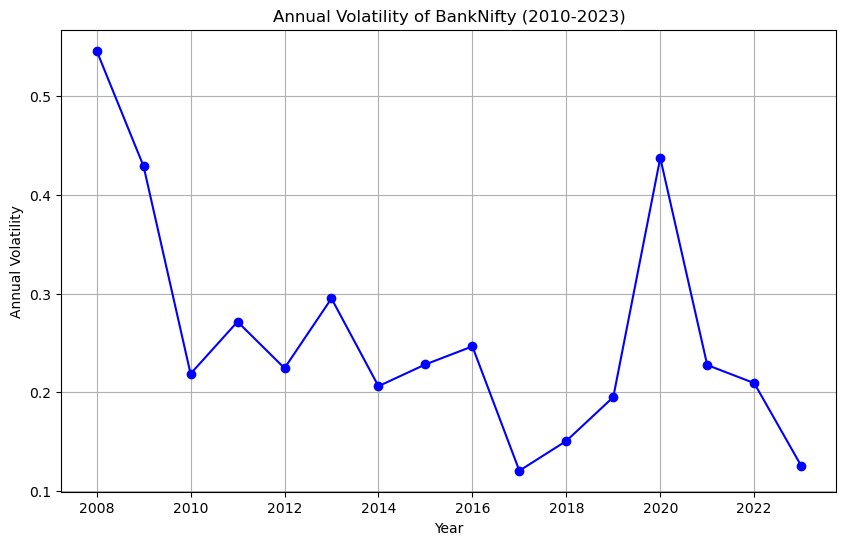

In [2]:
banknifty_data = yf.download('^NSEBANK', start='2008-01-01', end='2023-12-31', interval='1d')

banknifty_data.index = pd.to_datetime(banknifty_data.index)

annual_volatility = {}

for year in range(2000, 2024):
    yearly_data = banknifty_data.loc[banknifty_data.index.year == year]
    
    log_returns = np.log(yearly_data['Close'] / yearly_data['Close'].shift(1)).dropna()
    
    annual_volatility[year] = log_returns.std() * np.sqrt(len(log_returns))

plt.figure(figsize=(10, 6))
plt.plot(list(annual_volatility.keys()), list(annual_volatility.values()), marker='o', color='b', linestyle='-')
plt.title('Annual Volatility of BankNifty (2010-2023)')
plt.xlabel('Year')
plt.ylabel('Annual Volatility')
plt.grid(True)
plt.show()

We observe that over the span of the span of last 15 years, 2017 had the lowest volatilty of all.

<br>
Before we explain the trading strategy, first lets load in the required corresponding data.

In [3]:
stock_data = pd.read_csv("BNF_2017_cleaned.csv", parse_dates=['Date_Time'], index_col=['Date_Time'])
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93166 entries, 2017-01-02 09:15:00 to 2017-12-29 15:32:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Instrument  93166 non-null  object 
 1   Open        93166 non-null  float64
 2   High        93166 non-null  float64
 3   Low         93166 non-null  float64
 4   Close       93166 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.3+ MB


In [4]:
stock_data

,Instrument,Open,High,Low,Close
Date_Time,,,,,
2017-01-02 09:15:00,BANKNIFTY,18242.3,18242.3,18242.3,18242.3
2017-01-02 09:16:00,BANKNIFTY,18234.2,18249.0,18175.7,18181.2
2017-01-02 09:17:00,BANKNIFTY,18181.8,18194.7,18179.9,18184.4
2017-01-02 09:18:00,BANKNIFTY,18184.9,18189.3,18133.8,18133.8
2017-01-02 09:19:00,BANKNIFTY,18135.1,18141.6,18116.3,18138.9
...,...,...,...,...,...
2017-12-29 15:28:00,BANKNIFTY,25552.3,25553.4,25543.6,25547.5
2017-12-29 15:29:00,BANKNIFTY,25549.4,25551.0,25533.1,25542.1
2017-12-29 15:30:00,BANKNIFTY,25537.2,25551.4,25530.6,25530.6


In [5]:
raw_options_data = pd.read_csv("BANKNIFTY_FNO_Data_2017\BANKNIFTY_2017_OPTIONS.csv", parse_dates=[['Date','Time']])
raw_options_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5283597 entries, 0 to 5283596
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Date_Time         5283597 non-null  datetime64[ns]
 1   Ticker            5283597 non-null  object        
 2   Open              5283597 non-null  float64       
 3   High              5283597 non-null  float64       
 4   Low               5283597 non-null  float64       
 5   Close             5283597 non-null  float64       
 6   Volume            5283597 non-null  float64       
 7   OI                5283597 non-null  float64       
 8   Type              5283597 non-null  object        
 9   Strike            5283597 non-null  float64       
 10  Expiry            5283597 non-null  object        
 11  Contract_Monthly  5283597 non-null  object        
 12  Contract_Weekly   5283597 non-null  object        
dtypes: datetime64[ns](1), float64(7), object(5

In [6]:
options_data = raw_options_data[raw_options_data['Contract_Monthly'] == "I"].drop('Contract_Monthly', axis=1).set_index('Date_Time')
options_data

,Ticker,Open,High,Low,Close,Volume,OI,Type,Strike,Expiry,Contract_Weekly
Date_Time,,,,,,,,,,,
2017-01-02 09:15:59,BANKNIFTY25JAN1718300CE.NFO,311.45,325.00,293.75,293.75,400.0,20040.0,CE,18300.0,2017-01-25,IV
2017-01-02 09:15:59,BANKNIFTY25JAN1717000PE.NFO,55.00,57.00,53.15,56.35,2520.0,245720.0,PE,17000.0,2017-01-25,IV
2017-01-02 09:15:59,BANKNIFTY25JAN1717500PE.NFO,125.00,127.00,114.65,125.90,3800.0,407120.0,PE,17500.0,2017-01-25,IV
2017-01-02 09:15:59,BANKNIFTY25JAN1717900PE.NFO,204.60,217.20,204.50,217.20,200.0,14520.0,PE,17900.0,2017-01-25,IV
2017-01-02 09:15:59,BANKNIFTY25JAN1718000CE.NFO,497.80,497.80,468.15,469.00,2480.0,239360.0,CE,18000.0,2017-01-25,IV
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-29 15:29:59,BANKNIFTY25JAN1825600CE.NFO,324.30,325.95,324.00,325.95,280.0,41160.0,CE,25600.0,2018-01-25,IV
2017-12-29 15:29:59,BANKNIFTY25JAN1824000PE.NFO,34.30,35.00,33.55,33.70,1840.0,133200.0,PE,24000.0,2018-01-25,IV
2017-12-29 15:29:59,BANKNIFTY25JAN1823200PE.NFO,7.30,7.30,7.30,7.30,160.0,105120.0,PE,23200.0,2018-01-25,IV


The **OHLC**(Open, High, Low, Close) columns mentioned in the above datasets correspond to the options price(premium charged) movement during the 1-min time range.

The **Volume** represents the trading volume:-
1. High trading volume indicates strong liquidity, meaning you can enter and exit positions more easily without significant price impact. This reduces 'slippage' when executing trades.
2. A spike in volume may signal strong interest in a particular option, often reflecting trader sentiment about future price movements. Combine this indicator with the price movement to validate trend movements or reversals.

The **OI** represents the **Open Interest**:-
1. Increasing open interest alongside rising prices may indicate a strong trend, whereas declining open interest could suggest positions are being closed, potentially signaling a reversal.
2. Near expiration, OI can also give insight into where significant amounts of options are concentrated, such as strike price pinning, where the underlying stock tends to move toward a strike price with high OI close to expiration.

In [7]:
options_data.to_parquet('BNF_2017_options.parquet')

In [8]:
options = pd.read_parquet('BNF_2017_options.parquet')

## Main Loop

The options strategy is as follows:
1. **Initiate ATM Straddle Position:** Sell an at-the-money (ATM) straddle by simultaneously writing a call and a put option with identical strike prices and the same expiration date at the start of the trading day.
2. **Establish Protective OTM Wings:** To hedge against adverse price movements, purchase 3% out-of-the-money (OTM) wings. Specifically, buy an OTM call option with a strike price 3% above the ATM strike and an OTM put option with a strike price 3% below the ATM strike.
3. **Calculate Initial Premiums:** Determine the premium received from selling the ATM straddle (premium income) and the premium cost for the OTM wings. The recieved premium forms the basis for the strategy's risk-reward calculation.
4. **Set Stop Loss and Target Levels:** Define a 30% stop loss relative to the premium collected from the ATM straddle to limit potential losses. Establish a profit target at 100% of the premium received by selling the ATM straddle.
5. **Trade Monitoring and Exit Conditions:** Continuously track the trade throughout the day. Exit all legs of the position (both the straddle and the OTM wings) if the stop loss or target is triggered. If neither condition is met, close the entire position at the end of the trading day to avoid overnight risk exposure.

In the context of options trading, exiting a trade involves closing out the position by performing the opposite transaction of the initial one.
The difference between the net premium (premium recieved by selling ATM straddle minus the premium deposited for buying OTM wings) collected initially and the total cost of repurchasing the options (ATM and OTM) represents the net profit or loss of the strategy. If the stop loss or target levels are triggered, this repurchase amount will reflect the intended risk or reward defined by the strategy. This exit process ensures the trader no longer has obligations or exposure tied to the options sold, thus fully closing out the trade by balancing out all open positions.

If the datasets have a time column (like 'date') but do not share an exact index, merge_asof is ideal for aligning rows based on the nearest date, enabling vectorized operations.

In [9]:
combined_df = pd.merge_asof(options_data, stock_data, on='Date_Time', direction='nearest').set_index('Date_Time')
combined_df.head(30)

,Ticker,Open_x,High_x,Low_x,Close_x,Volume,OI,Type,Strike,Expiry,Contract_Weekly,Instrument,Open_y,High_y,Low_y,Close_y
Date_Time,,,,,,,,,,,,,,,,
2017-01-02 09:15:59,BANKNIFTY25JAN1718300CE.NFO,311.45,325.00,293.75,293.75,400.0,20040.0,CE,18300.0,2017-01-25,IV,BANKNIFTY,18234.2,18249.0,18175.7,18181.2
2017-01-02 09:15:59,BANKNIFTY25JAN1717000PE.NFO,55.00,57.00,53.15,56.35,2520.0,245720.0,PE,17000.0,2017-01-25,IV,BANKNIFTY,18234.2,18249.0,18175.7,18181.2
2017-01-02 09:15:59,BANKNIFTY25JAN1717500PE.NFO,125.00,127.00,114.65,125.90,3800.0,407120.0,PE,17500.0,2017-01-25,IV,BANKNIFTY,18234.2,18249.0,18175.7,18181.2
2017-01-02 09:15:59,BANKNIFTY25JAN1717900PE.NFO,204.60,217.20,204.50,217.20,200.0,14520.0,PE,17900.0,2017-01-25,IV,BANKNIFTY,18234.2,18249.0,18175.7,18181.2
2017-01-02 09:15:59,BANKNIFTY25JAN1718000CE.NFO,497.80,497.80,468.15,469.00,2480.0,239360.0,CE,18000.0,2017-01-25,IV,BANKNIFTY,18234.2,18249.0,18175.7,18181.2
2017-01-02 09:15:59,BANKNIFTY25JAN1718000PE.NFO,290.00,290.00,247.85,260.00,2520.0,501440.0,PE,18000.0,2017-01-25,IV,BANKNIFTY,18234.2,18249.0,18175.7,18181.2
2017-01-02 09:15:59,BANKNIFTY25JAN1718100CE.NFO,406.80,406.80,406.80,406.80,40.0,10840.0,CE,18100.0,2017-01-25,IV,BANKNIFTY,18234.2,18249.0,18175.7,18181.2
2017-01-02 09:15:59,BANKNIFTY25JAN1718100PE.NFO,293.40,293.40,293.40,293.40,40.0,12320.0,PE,18100.0,2017-01-25,IV,BANKNIFTY,18234.2,18249.0,18175.7,18181.2
2017-01-02 09:15:59,BANKNIFTY25JAN1718200CE.NFO,358.10,371.05,350.05,350.05,360.0,39760.0,CE,18200.0,2017-01-25,IV,BANKNIFTY,18234.2,18249.0,18175.7,18181.2


In [10]:
### MAIN LOOP ###
Total_PnL = 0
Portfolio_value = 100000    # We start with a 1 Lakh Capital
results = []                # list to store the trades
for date, date_group in list(combined_df.groupby(combined_df.index.date)):
    entry = False
    exit = False
    entry_time = (date_group.index[0] + pd.Timedelta(minutes=15)).to_pydatetime().time()
    exit_time = (date_group.index[-1] - pd.Timedelta(minutes=10)).to_pydatetime().time()

    for time, time_group in list(date_group.groupby(date_group.index.time)):
        if time < entry_time or exit or time > exit_time:
            continue

        if not entry:
            # Step 1: Identify non-unique strike prices
            non_unique_strikes = time_group['Strike'][time_group['Strike'].duplicated(keep=False)]

            # Step 2: Filter the DataFrame to keep only non-unique strike prices
            filtered_df = time_group[time_group['Strike'].isin(non_unique_strikes)]
            if len(filtered_df) > 0:
                # Step 3: Calculating the ATM offset, to find the closest options
                filtered_df['atm_offset'] = np.abs(filtered_df['Close_y'] - filtered_df['Strike'])
                
                # Step 4: Sort by atm_offset to find the closest options
                closest_options = filtered_df.sort_values(['atm_offset'], ascending=True)

                # Select a subset of the closest options with the smallest atm_offset
                smallest_atm_offset = closest_options['atm_offset'].min()
                filtered_closest_options = closest_options[closest_options['atm_offset'] == smallest_atm_offset]

                # Step 5: Group by Expiry and find the best pair based on OI
                atm_pair = None
                max_oi_sum = 0
                
                for expiry, expiry_group in filtered_closest_options.groupby('Expiry'):
                    # Select Calls and Puts separately
                    calls = expiry_group[expiry_group['Type'] == 'CE']
                    puts = expiry_group[expiry_group['Type'] == 'PE']

                    # Check if both Call and Put options exist
                    if not calls.empty and not puts.empty:
                        # Get the maximum OI from Calls and Puts
                        max_call_oi = calls['OI'].max()
                        max_put_oi = puts['OI'].max()

                        # Find the pair with the highest total OI
                        if max_call_oi + max_put_oi > max_oi_sum:
                            max_oi_sum = max_call_oi + max_put_oi
                            atm_pair = [calls[calls['OI'] == max_call_oi], puts[puts['OI'] == max_put_oi]]

                # Step 6: Get the ATM Strike Price and options tickers
                atm_strike = atm_pair[0]['Strike'].item()
                atm_tickers = [atm_pair[0]['Ticker'].item(), atm_pair[1]['Ticker'].item()]

                # Step 7: Removing the ATM options from the list of options
                remaining_options = time_group[time_group['Strike'] != atm_strike]
                
                # Step 8: Obtaining 2% away wings for protection
                for type, type_group in remaining_options.groupby('Type'):
                    # Calculating OTM price of the option based on Type (Call or Put) of option
                    otm_price = 1.03 * atm_strike if type == 'CE' else 0.97 * atm_strike

                    # Calculating the otm offset and finding the closest options
                    type_group['otm_offset'] = np.abs(type_group['Strike'] - otm_price)
                    closest_options = type_group.sort_values(['otm_offset'], ascending=True)

                    # Select a subset of the closest options with the smallest otm_offset
                    smallest_otm_offset = closest_options['otm_offset'].min()
                    filtered_otm_closest_options = closest_options[closest_options['otm_offset'] == smallest_otm_offset]

                    # Declaring variables for storing the options
                    locals()['otm_' + type] = filtered_otm_closest_options.sort_values(['Close_x']).iloc[0]
                
                # Step 9: Getting the Strike Prices and options tickers
                otm_call_strike = otm_CE['Strike'].item()
                otm_put_strike = otm_PE['Strike'].item()
                otm_call_ticker = otm_CE['Ticker']
                otm_put_ticker = otm_PE['Ticker']

                # print(f'    OTM options are: {otm_call_ticker, otm_put_ticker}')

                entry = True
                trade_entry = time
                entry_spot_price = otm_CE['Close_y'].item()
                
                # Calculating the premium calculated from selling the atm straddle
                premium_atm = atm_pair[0]['Close_x'].item() + atm_pair[1]['Close_x'].item()
                premium_otm = otm_CE['Close_x'].item() + otm_PE['Close_x'].item()
                
                # Calculating the Stop Loss and Target based of the premium collected
                sl = 0.2 * premium_atm
                target = premium_atm

        # Observe the movement of the underlying stock
        spot_price = time_group['Close_y'].iloc[0]

        # Get the current prices of portfolio options
        current_closing_price_atm_call = time_group[time_group['Ticker'] == atm_tickers[0]]['Close_x']
        current_closing_price_atm_put = time_group[time_group['Ticker'] == atm_tickers[1]]['Close_x']
        current_closing_price_otm_call = time_group[time_group['Ticker'] == otm_call_ticker]['Close_x']
        current_closing_price_otm_put = time_group[time_group['Ticker'] == otm_put_ticker]['Close_x']

        # Check if prices for all options are available in the options dataset for the current time
        if not any(s.empty for s in [current_closing_price_atm_call, current_closing_price_atm_put, current_closing_price_otm_call, current_closing_price_otm_put]):
            closing_price_atm_call = current_closing_price_atm_call.item()
            closing_price_atm_put = current_closing_price_atm_put.item()
            closing_price_otm_call = current_closing_price_otm_call.item()
            closing_price_otm_put = current_closing_price_otm_put.item()
            closing_time = time

            # Price of Closing all legs of trades
            atm_straddle_closing_price = closing_price_atm_call + closing_price_atm_put
            otm_wings_closing_price = closing_price_otm_call + closing_price_otm_put

            pnl = premium_atm - atm_straddle_closing_price + otm_wings_closing_price - premium_otm

        # Checking if Exit criteria are satistified
        if (pnl <= -sl) or (pnl >= target) or (time >= exit_time):

            exit = True
            exit_pnl = pnl * 100
            Portfolio_value +=exit_pnl
            Total_PnL += exit_pnl
            results.append((date,
                            trade_entry, 
                            closing_time,

                            entry_spot_price,
                            spot_price,

                            atm_strike,
                            otm_call_strike,
                            otm_put_strike,

                            atm_pair[0]['Close_x'].item(),
                            closing_price_atm_call,

                            atm_pair[1]['Close_x'].item(),
                            closing_price_atm_put,

                            otm_CE['Close_x'].item(),
                            closing_price_otm_call,

                            otm_PE['Close_x'].item(),
                            closing_price_otm_put,
                            
                            exit_pnl,
                            Total_PnL,
                            Portfolio_value,
                            exit_pnl/(Portfolio_value-exit_pnl)
                            ))

In [11]:
results_df = pd.DataFrame(results, columns=['Date',
                                            'En_time',
                                            'Ex_time',

                                            'Asset_En_Pice',
                                            'Asset_Ex_Price',

                                            'ATM_Strike',
                                            'OTM_Call_Strike',
                                            'OTM_Put_Strike',

                                            'ATM_Call_En_Price',
                                            'ATM_Call_Ex_Price',

                                            'ATM_Put_En_Price',
                                            'ATM_Put_Ex_Price',

                                            'OTM_Call_En_Price',
                                            'OTM_Call_Ex_Price',

                                            'OTM_Put_En_Price',
                                            'OTM_Put_Ex_Price',

                                            'Exit PnL',
                                            'Cumulative PnL',
                                            'Total Portfolio Value',
                                            'Portfolio_pct_return']).set_index('Date')

In [12]:
results_df.to_excel('TradeReport.xlsx')

## Visualization and Performance Metrics Calculation

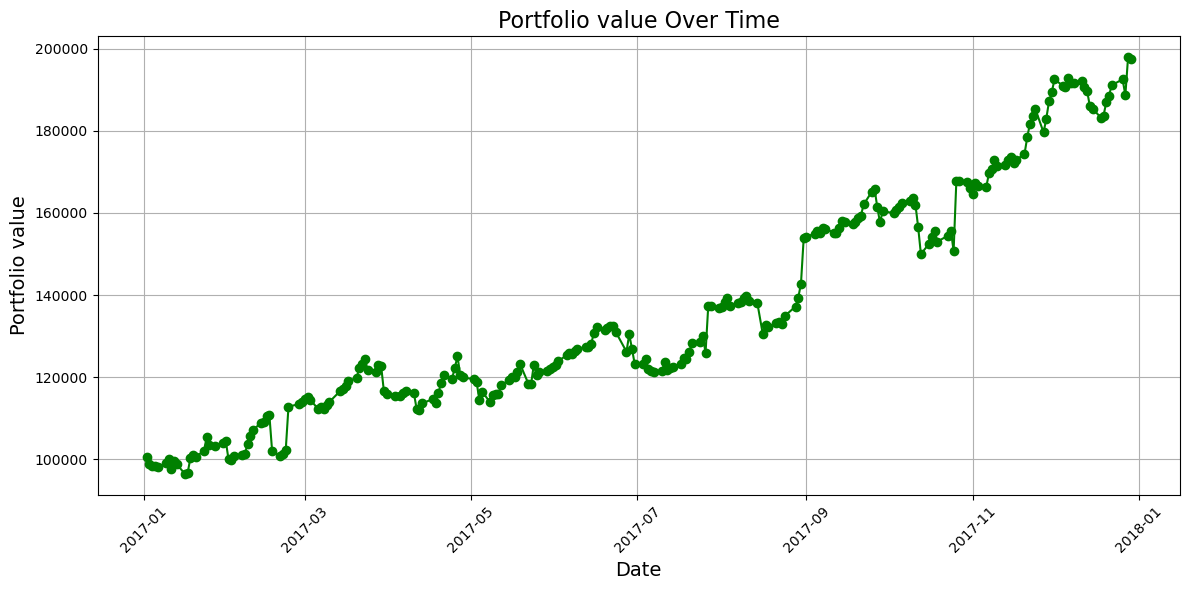

In [13]:
# Plot the cumulative PnL over time
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Total Portfolio Value'], marker='o', linestyle='-', color='g')
plt.title('Portfolio value Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio value', fontsize=14)
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Sharpe Ratio Calculation on daily returns annualized
log_returns = np.log(results_df['Total Portfolio Value']/results_df['Total Portfolio Value'].shift(1)).dropna()

sharpe_ratio = (log_returns.mean() / log_returns.std()) * np.sqrt(246)
sharpe_ratio

2.167906119650443

In [15]:
# Max Drawdown Calculation
rolling_max = results_df['Cumulative PnL'].cummax()  # Find cumulative max of returns
drawdown = results_df['Cumulative PnL'] - rolling_max  # Calculate drawdown
drawdown.min()

-15915.000000000015

In [16]:
# Max Drawdown Calculation
results_df['cumulative_max'] = results_df['Total Portfolio Value'].cummax()
results_df['drawdown'] = (results_df['Total Portfolio Value'] - results_df['cumulative_max']) / results_df['cumulative_max']

max_drawdown = results_df['drawdown'].min() * 100
max_drawdown

-10.010842067220814

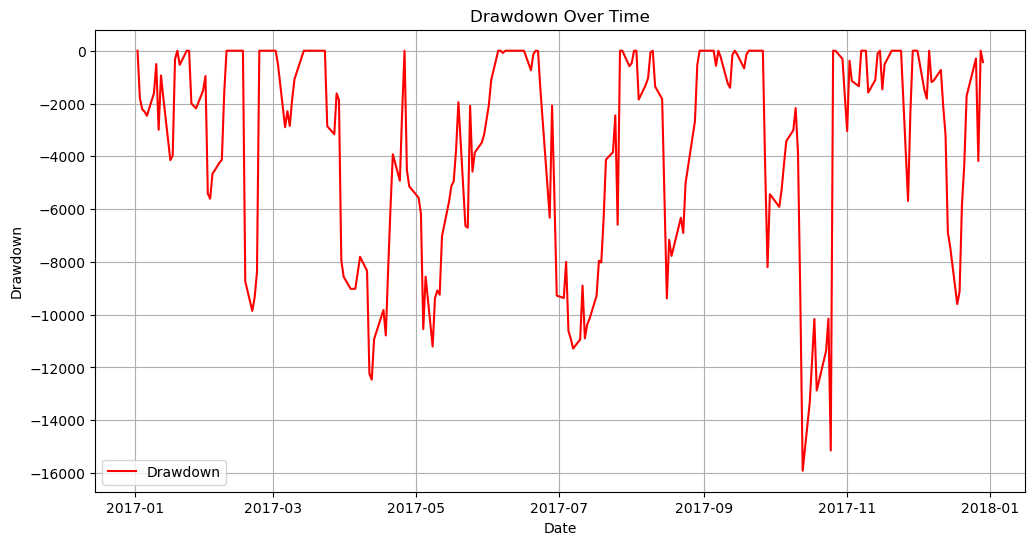

In [17]:
# Plot drawdown
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, drawdown, label='Drawdown', color='r')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid()
plt.show()